# Imorting Files

In [1]:
import pandas as pd

In [2]:
links = pd.read_csv('csv_files/links.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies = pd.read_csv('csv_files/movies.csv')

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [109]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
ratings = pd.read_csv('csv_files/ratings.csv')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [110]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [113]:
ratings['rating'].value_counts(normalize=True)

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64

In [8]:
tags =  pd.read_csv('csv_files/tags.csv')

In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
new_df = ratings.drop(columns='timestamp')

# Recommendation System

In [16]:
from surprise import Reader, Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [17]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(new_df[['userId', 'movieId', 'rating']], reader)

## Chosing Prediction Algorithms

In [14]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.868845,882.926506,32.773629
BaselineOnly,0.876045,0.222493,0.456649
SVD,0.879474,9.959715,0.614917
KNNBaseline,0.881853,0.539366,7.746760
KNNWithMeans,0.905121,0.386333,6.592975
KNNWithZScore,0.905275,0.452219,6.905525
SlopeOne,0.912581,6.849113,21.746805
NMF,0.934993,11.795354,0.525171
CoClustering,0.955518,5.107392,0.581912


For time constraints the model will be using BaselineOnly

## Fine Tunning Parameters

In [16]:
# Fine tuning paramaters
param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                             'reg': [0.2, 0.4, 0.6],
                             'reg_i': [5,10,15],
                             'reg_u' : [10,15,20],
                             'learning_rate': [0.003, 0.005, 0.008],
                             'n_epochs': [75,100,125]}}

In [123]:
gs = GridSearchCV(BaselineOnly, param_grid = param_grid , measures=['rmse'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [18]:
print('Using ALS')
bsl_options = {'method': 'als',
               'reg': 0.2,
               'n_epochs': 100,
               'reg_u': 10,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.86875549, 0.8690588 , 0.8738186 ]),
 'fit_time': (1.8211925029754639, 1.8048055171966553, 1.7306957244873047),
 'test_time': (0.48267340660095215, 0.4982151985168457, 0.5425856113433838)}

In [19]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8663


0.8662802989343349

## Top 5 Recommendations

In [20]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['est'] =  round(df['est'] * 2) / 2
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [21]:
df = pd.merge(df, movies, left_on = 'iid', right_on = 'movieId')

In [22]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [23]:
 df.loc[df['uid'] == 1].sort_values(by='err').head()

,uid,iid,rui,est,details,Iu,Ui,err,movieId,title,genres
8217,1,608,5.0,5.0,{'was_impossible': False},177,135,0.0,608,Fargo (1996),Comedy|Crime|Drama|Thriller
18518,1,3617,4.0,4.0,{'was_impossible': False},177,32,0.0,3617,Road Trip (2000),Comedy
15078,1,2143,4.0,4.0,{'was_impossible': False},177,8,0.0,2143,Legend (1985),Adventure|Fantasy|Romance
3422,1,1805,4.0,4.0,{'was_impossible': False},177,22,0.0,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
14764,1,2046,4.0,4.0,{'was_impossible': False},177,16,0.0,2046,Flight of the Navigator (1986),Adventure|Children|Sci-Fi


# Cold Start #1

User rates list of movies and is given recommendations based on input

In [24]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list     

In [25]:
user_rating = movie_rater(movies, 4, 'Action')

      movieId                     title                 genres
4615     6874  Kill Bill: Vol. 1 (2003)  Action|Crime|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId             title                             genres
4809     7164  Peter Pan (2003)  Action|Adventure|Children|Fantasy
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                         title                          genres
5434    25946  Three Musketeers, The (1948)  Action|Adventure|Drama|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                                           title  \
7063    69524  Raiders of the Lost Ark: The Adaptation (1989)   

                         genres  
7063  Action|Adventure|Thriller  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2


In [26]:
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [27]:
# train a model using the new combined DataFrame
baseline = BaselineOnly(bsl_options=bsl_options)
baseline.fit(new_data.build_full_trainset())

Estimating biases using als...


In [28]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in new_df['movieId'].unique():
    list_of_movies.append( (m_id,baseline.predict(1000,m_id)[3]))

In [29]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [30]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  4 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

Recommendation #  5 :  2226    Fight Club (1999)
Name: title, dtype: object 



# Cold Start #2

Display a list of the most watched movies based on the amount of times the movie has been rated and the average rating of the moive

In [97]:
top = df.groupby('title').mean()

In [98]:
top.drop(['uid', 'est', 'Iu', 'err', 'iid'], axis = 1, inplace = True)

In [99]:
top.rename(columns = {'rui':'average_rating', 'Ui':'number_of_ratings'}, inplace = True) 
top.sort_values(by = ['number_of_ratings', 'average_rating'], ascending = False).head()

,average_rating,number_of_ratings,movieId
title,,,
"Shawshank Redemption, The (1994)",4.429412,232.0,318.0
Forrest Gump (1994),4.092784,232.0,356.0
Pulp Fiction (1994),4.026882,214.0,296.0
"Matrix, The (1999)",4.115942,209.0,2571.0
"Silence of the Lambs, The (1991)",4.273333,204.0,593.0


In [100]:
top.reset_index(inplace=True)

In [101]:
top['title'] = [top['title'][i].strip() for i in range(len(top))]

In [102]:
top['release_year'] = [top['title'][i][-5:-1] for i in range(len(top))]

In [103]:
top.drop([1180, 3679, 3871, 4160, 5043], inplace=True)

In [104]:
top['release_year']= top['release_year'].astype(float)

In [105]:
top['decade'] = top['release_year']//10*10

In [106]:
full = pd.merge(top, movies, on = 'title')
full.drop('movieId_y', axis=1, inplace=True)

In [107]:
def user_data(gender, age):
    u_age = 2020-age
    if gender == 'male':
        ud = full[(full['genres'].str.contains('Action' or 'Adventure' or 'Thriller')) & (full['release_year'] >= age)].head()
    if gender == 'female':
        ud = full[(full['genres'].str.contains('Drama' or 'Romance' or 'Musical')) & (full['release_year'] >= age)].head()
    ud = ud.sort_values(by = ['number_of_ratings', 'average_rating'], ascending = False).head()
    display(ud)

In [115]:
user_data('male', 23)

,title,average_rating,number_of_ratings,movieId_x,release_year,decade,genres
26,"13th Warrior, The (1999)",3.214286,19.0,2826.0,1999.0,1990.0,Action|Adventure|Fantasy
36,"2 Fast 2 Furious (Fast and the Furious 2, The)...",3.000000,18.0,6383.0,2003.0,2000.0,Action|Crime|Thriller
37,2 Guns (2013),4.000000,2.0,103883.0,2013.0,2010.0,Action|Comedy|Crime
21,13 Assassins (Jûsan-nin no shikaku) (2010),4.333333,1.0,86142.0,2010.0,2010.0,Action
0,'Hellboy': The Seeds of Creation (2004),4.000000,0.0,97757.0,2004.0,2000.0,Action|Adventure|Comedy|Documentary|Fantasy


# EDA

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

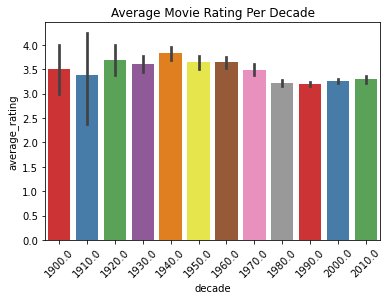

In [298]:
chart = sns.barplot(x='decade', y='average_rating', data = top, palette = 'Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Average Movie Rating Per Decade');

In [281]:
c = top[(top['release_year'] >= 1990)& (top['release_year'] <= 1999)]

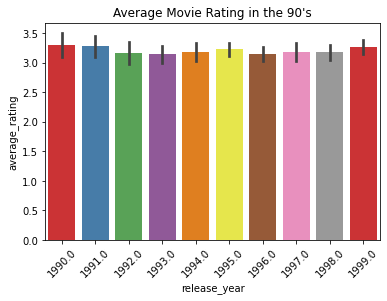

In [300]:
chart = sns.barplot(x='release_year', y='average_rating', data = c, palette = 'Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Average Movie Rating in the 90\'s');

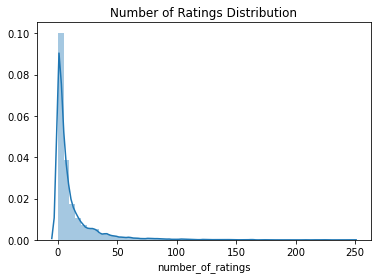

In [307]:
sns.distplot(top['number_of_ratings'])
plt.title('Number of Ratings Distribution');

In [116]:
print('% unrated movies with 0 reviews:')
print(round((len(top[top['number_of_ratings'] == 0]) / len(top) * 100), 2))
print('-----')
print('% unrated movies with less than 10 reviews:')
print(round((len(top[top['number_of_ratings'] <= 10]) / len(top) * 100), 2))


% unrated movies with 0 reviews:
16.88
-----
% unrated movies with less than 10 reviews:
70.3


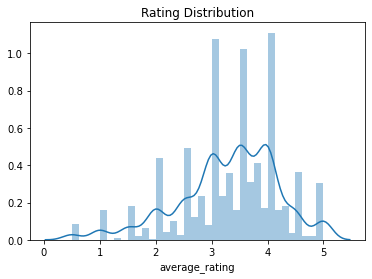

In [306]:
sns.distplot(top['average_rating'])
plt.title('Rating Distribution');

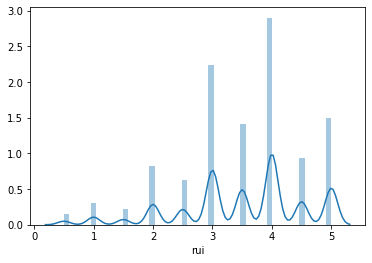

In [289]:
sns.distplot(df['rui']);

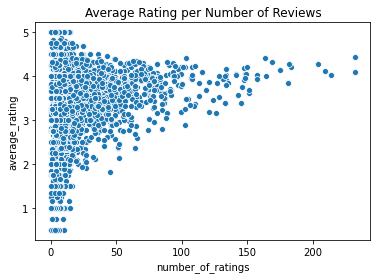

In [125]:
sns.scatterplot(x='number_of_ratings', y='average_rating', data = top)
plt.title('Average Rating per Number of Reviews');

In [293]:
s = top[top['average_rating'] == 5]
s.sort_values(by='number_of_ratings', ascending=False)

,title,average_rating,number_of_ratings,movieId,release_year,decade
4417,Serendipity (2001),5.0,24.0,4823.0,2001.0,2000.0
275,Amores Perros (Love's a Bitch) (2000),5.0,22.0,4235.0,2000.0,2000.0
2902,"Last King of Scotland, The (2006)",5.0,19.0,48738.0,2006.0,2000.0
3767,"Outlaw Josey Wales, The (1976)",5.0,16.0,3508.0,1976.0,1970.0
1135,"Conversation, The (1974)",5.0,16.0,3730.0,1974.0,1970.0
...,...,...,...,...,...,...
2590,Investigation Held by Kolobki (1986),5.0,0.0,172583.0,1986.0,1980.0
2581,Into the Woods (1991),5.0,0.0,8580.0,1991.0,1990.0
2579,Into the Abyss (2011),5.0,0.0,90943.0,2011.0,2010.0
2418,"Human Condition III, The (Ningen no joken III)...",5.0,0.0,26073.0,1961.0,1960.0
